In [14]:
import optlib as opt
import numpy as np

### Creating American Put Option and grid

In [15]:
# setting the underlying
stock = opt.Underlying(65, 0.3, 0.3)
# creating the American Put option
AmPut = opt.Option(stock, "American", False, 50)
# creating the grid and adding option's parameters
grid = opt.Grid(300, 100, -4.0, 1)
grid.addOption(AmPut)
# setting boundary conditions
grid.setBoundsPut()
# getting the grid
u = grid.net

### Setting Matrix for calculations

In [16]:
n = grid.xSteps
# matrix for explicit step
B = np.zeros((n+1, n+1))
for i in range(1, n+1):
    B[i, i] = 1 - grid.lamda
    B[i, i-1] = grid.lamda/2
    B[i-1, i] = grid.lamda/2
# diagonals of the A matrix (implicit step):
alpha = (1 + grid.lamda) * np.ones(n-1)
beta = -0.5 * grid.lamda * np.ones(n-2)

### Brennan-Schwartz algorythm implementation

In [17]:
# brennan-shwartz algorythm
for i in np.arange(0, grid.tSteps):
    # setting early execution curve
    time = grid.tGrid[i+1]
    g = np.array(tuple(map(lambda x : opt.g_func(grid.q, time, x), grid.xGrid)))
    # explicit step
    f_hat = u[:,i].copy()
    f_hat[0] = f_hat[0] + grid.lamda * g[0] / 2
    f_hat[n] = f_hat[n] + grid.lamda * g[n] / 2
    f = np.dot(B, f_hat)
    # implicit step
    solution = opt.brennan_schwartz(alpha, beta, beta, f[1:n], g)
    u[1:n,i+1] = solution

# adding result to grid
grid.net = u
# transforming coordinates
grid.toNormal(True)

### Plotting grid with Early execution Curve

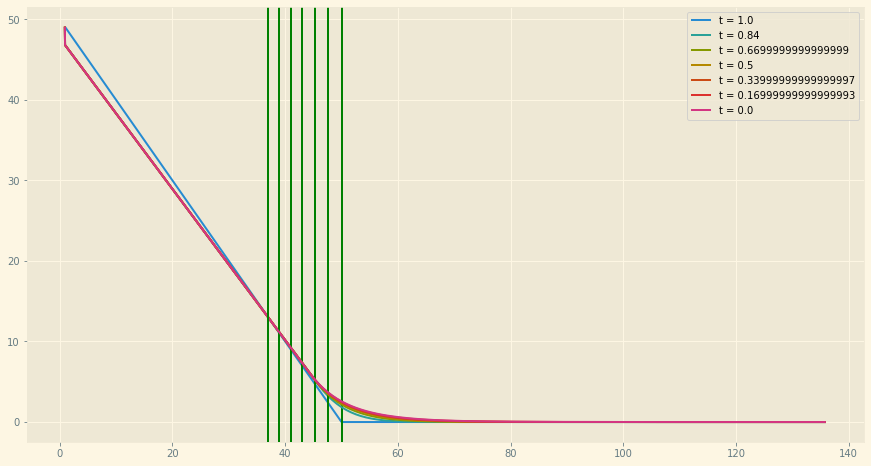

In [18]:
grid.plot()
grid.plot(7)

### Valuating European Put option with the same Underlying, Strike and Maturity

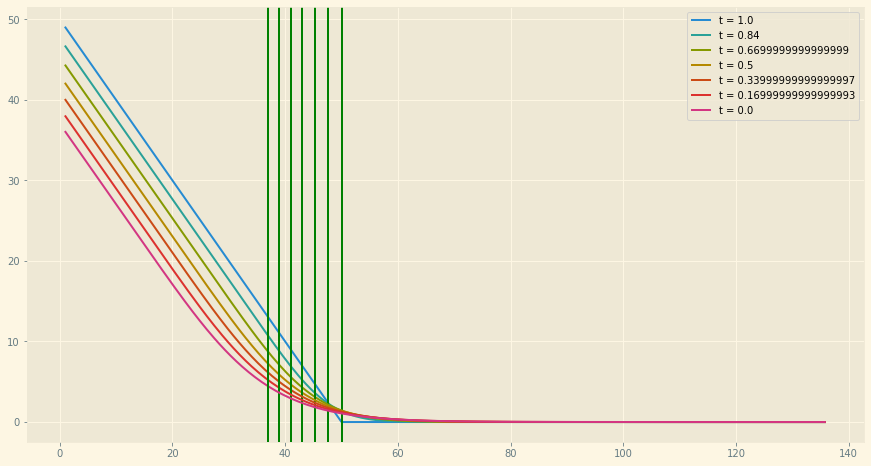

In [25]:
EuPut = opt.Option(stock, "European", False, 50)
# creating the grid and adding option's parameters
grid2 = opt.Grid(300, 100, -4.0, 1)
grid2.addOption(EuPut)
grid2.valuateBSM()
grid2.plot(7)

### Plotting the difference between American and European

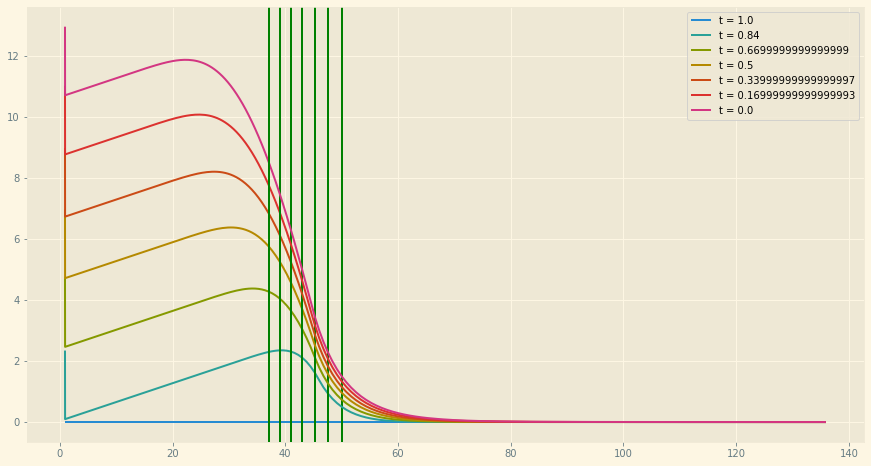

In [26]:
grid2.net = grid.net - grid2.net
grid2.plot()
grid2.plot(7)